In [67]:
import os
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import keras
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# run once
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jonathan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jonathan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jonathan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Reading in the Data

In [2]:
def read_data(file):
    '''
    Read each text file into a string
    '''
    f = open(file, 'r', encoding='utf8')
    text = f.read()
    f.close()
    return text

def folder_list(path):
    '''
    Reads each text file in a folder and concatenates each file into a bigger string
    Parameter 'path' is the path of your local folder.
    '''
    filelist = os.listdir(path)
    text = ''
    for infile in filelist:
        file = os.path.join(path,infile)
        text_data = read_data(file)
        text += '\n ' + text_data
    return text

def load_and_shuffle_data():
    path = "data/"

    text = folder_list(path)
    #print(text)
    #random.shuffle(text)
    
    return text

In [3]:
data = load_and_shuffle_data()
#print(data)

# 2. Text Preprocessing

### a. Expand Contractions
example: I'm -> I am

In [4]:
CONTRACTION_MAP = { 
"ain't": "am not",
"aren't": "am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        #print(match)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        #print(expanded_contraction)
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [5]:
#test
print(expand_contractions('''test: it's I'll I'm haven't''',CONTRACTION_MAP))

test: it is I will I am have not


### b. Remove non-alphabetical characters
Remove special characters like periods, commas, as well as digits. Only keeping alphabet characters and spaces

In [6]:
def remove_non_alphabetical_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [7]:
#test
print(remove_non_alphabetical_characters('t !@#$%^&*()_+-={}[]:"e;''">? s ./\|<>,t1234567890`'))

t e s t


### c. Removing stopwords
example: remove 'a', 'the', 'and', etc.

In [8]:
def remove_stopwords(text):
    stopword_list = set(stopwords.words('english')) 
    
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    
    return ' '.join(filtered_tokens) 

In [9]:
#test
print(remove_stopwords('this test is a test to test the test from a test'))

test test test test test


### d. Stemming 
#### (may remove due to aggressive pruning issue + lemmatization being more effective)
example: making -> make

In [10]:
def stemmer_text(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [11]:
print(stemmer_text('making make makes'))
print(stemmer_text('try tries ponies us')) # issue with stemming - https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e

make make make
tri tri poni us


### e. Lemmatization
example: tries -> try

In [12]:
def lemmatize_text(text):
    wn_lemmatizer = WordNetLemmatizer()
    text = ' '.join([wn_lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [13]:
#test
print(lemmatize_text('making make makes'))
print(lemmatize_text('try tries ponies us'))

making make make
try try pony u


In [14]:
def preprocess(text):
    text = text.lower()
    #text = [j for sub in text for j in sub]  # flatten list of all books into 1d list
    #text = [word.lower() for word in text]
    text = expand_contractions(text)
    text = remove_non_alphabetical_characters(text)
    text = remove_stopwords(text)
    #text = stemmer_text(text)
    text = lemmatize_text(text)
    return text

In [15]:
preprocessed_text = preprocess(data)
#print(preprocessed_text)

In [16]:
tokens = preprocessed_text.split()
print('Number of words: ' +str(len(tokens)))
print('Number of unique words: ' +str(len(set(tokens))))

Number of words: 243801
Number of unique words: 18023


# 3. Sequence of words + integer encoding 

In [17]:
# Load all tokens into sequences (so that model can learn to predict words after a given sequence)
# see https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 243750


In [228]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

out_filename = 'sequences50.txt'
save_doc(sequences, out_filename)

# 4. Train model

In [34]:
import keras

# used to save the keras model every 10 epochs
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [20]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load
in_filename = 'sequences50.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [21]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
 
# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [36]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length)) #create word embedding, better than BoW
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
saver = CustomSaver()
history = model.fit(X, y, callbacks=[saver], batch_size=128, epochs=100, validation_split=0.2)
 
#model.save('model50.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            901200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 100)           60400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 18024)             1820424   
Total params: 2,872,524
Trainable params: 2,872,524
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 195000 samples, validate on 48750 samples
Epoch 1/100
195000/195000 [==============================] - 406s 2ms/step - loss: 8.1087 - accuracy: 0.0098 - val_loss: 8.4298 - val_accuracy: 0.0121
Epoch 2/100
195000/195000 [==============================] - 386s 2ms/step - loss: 7.8475 - accuracy: 0.0123 - val_loss: 8.4770 - val_accuracy: 0.0110
Epoch 3/100
195000/195000 [==============================] - 402s 2ms/step - loss: 7.6433 - accuracy: 0.0167 - val_loss: 8.5538 - val_accuracy: 0.0105
Epoch 4/100
195000/195000 [==============================] - 390s 2ms/step - loss: 7.4510 - accuracy: 0.0219 - val_loss: 8.6428 - val_accuracy: 0.0108
Epoch 5/100
195000/195000 [==============================] - 457s 2ms/step - loss: 7.2760 - accuracy: 0.0266 - val_loss: 8.7487 - val_accuracy: 0.0119
Epoch 6/100
195000/195000 [==============================] - 461s 2ms/step - loss: 7.0942 - accuracy: 0.0309 - val_loss: 8.8569 - val_accuracy: 0.0107
Epoch 7/100
195000/195000 [================

195000/195000 [==============================] - 408s 2ms/step - loss: 3.4174 - accuracy: 0.3298 - val_loss: 32.3963 - val_accuracy: 0.0029
Epoch 55/100
195000/195000 [==============================] - 407s 2ms/step - loss: 3.3849 - accuracy: 0.3337 - val_loss: 32.6961 - val_accuracy: 0.0030
Epoch 56/100
195000/195000 [==============================] - 419s 2ms/step - loss: 3.3543 - accuracy: 0.3381 - val_loss: 33.1385 - val_accuracy: 0.0026
Epoch 57/100
195000/195000 [==============================] - 403s 2ms/step - loss: 3.3231 - accuracy: 0.3431 - val_loss: 33.2528 - val_accuracy: 0.0026
Epoch 58/100
195000/195000 [==============================] - 423s 2ms/step - loss: 3.2931 - accuracy: 0.3474 - val_loss: 33.7993 - val_accuracy: 0.0027
Epoch 59/100
195000/195000 [==============================] - 401s 2ms/step - loss: 3.2618 - accuracy: 0.3517 - val_loss: 34.0325 - val_accuracy: 0.0027
Epoch 60/100
195000/195000 [==============================] - 463s 2ms/step - loss: 3.2345 - ac

## 4b. Training analysis

In [72]:
df = pd.DataFrame()
df['epoch'] = range(100)
df['train_loss'] = history.history['loss']
df['train_acc'] = history.history['accuracy']
df['val_loss'] = history.history['val_loss']
df['val_acc'] = history.history['val_accuracy']

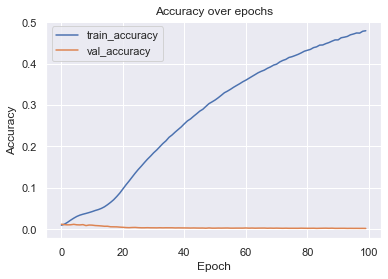

In [77]:
sns.set(style="darkgrid")
plt.plot(range(100),history.history['accuracy'], label='train_accuracy')
plt.plot(range(100),history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

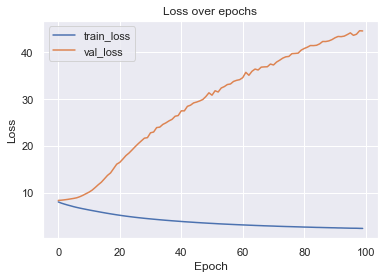

In [78]:
plt.plot(range(100),history.history['loss'], label='train_loss')
plt.plot(range(100),history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# 5. Text generation (after training)

In [37]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [38]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [46]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    
    result = list()
    in_text = seed_text
    
    # generate a fixed number of words
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]  # encode the text as integer
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')  # truncate sequences to a fixed length
        yhat = model.predict_classes(encoded, verbose=0)  # predict probabilities for each word
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
                
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [53]:
# load cleaned text sequences
in_filename = 'sequences50.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# a. Earlier model (trained for 10 epochs)

In [54]:
# load the model
model = load_model('model_0.hd5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [55]:
# select a random seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

breakfast cap dear man bonnet best gotoconcertandtheater bonnet beg pardon small naturally mistook one flyaway thing sometimes wear keep bit lace fastened chin rosebud meg illustrated putting bonnet regarding air calm satisfaction irresistible love bonnet prefer face inside look young happy john kissed smiling face great detriment rosebud chin glad like

said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said said


# b. Final model (trained for 100 epochs)

In [50]:
# load the model
model = load_model('model_90.hd5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [52]:
# select a random seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

never felt alone surrounded dog socially inferior hook true name reveal really would even date set country blaze read line must already guessed famous public school tradition still clung like garment indeed largely concerned thus offensive even board ship dress grappled still adhered walk school distinguished slouch retained passion good form

come downwind one pathetic mysterious various ledge wall invited frollo thou mean glorious revenged gate zara lean red rose oddly obstacle phlegmatic gay wall mud fire red trickle game mist tried elation ship stole field smoked two exploding suit saw house like grappled never face laugh grappled put danger sin
